<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/VGG19_SEVERE/vecicle_damage_VGG19_epoch_100_severity__dataset_updaated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1060 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 225 images belonging to 3 classes.


Epoch 1/60
66/66 [==============================] - 22s 315ms/step - loss: 3.0573 - accuracy: 0.4454 - val_loss: 0.8394 - val_accuracy: 0.5625
Epoch 2/60
66/66 [==============================] - 20s 299ms/step - loss: 0.8362 - accuracy: 0.5948 - val_loss: 0.7741 - val_accuracy: 0.5982
Epoch 3/60
66/66 [==============================] - 22s 326ms/step - loss: 0.8090 - accuracy: 0.6322 - val_loss: 0.7925 - val_accuracy: 0.5938
Epoch 4/60
66/66 [==============================] - 19s 289ms/step - loss: 0.7842 - accuracy: 0.6398 - val_loss: 0.7463 - val_accuracy: 0.6250
Epoch 5/60
66/66 [==============================] - 21s 311ms/step - loss: 0.7634 - accuracy: 0.6427 - val_loss: 0.8243 - val_accuracy: 0.5670
Epoch 6/60
66/66 [==============================] - 25s 376ms/step - loss: 0.7499 - accuracy: 0.6446 - val_loss: 0.7492 - val_accuracy: 0.6339
Epoch 7/60
66/66 [==============================] - 20s 306ms/step - loss: 0.7034 - accuracy: 0.6830 - val_loss: 0.7524 - val_accuracy: 0.6071

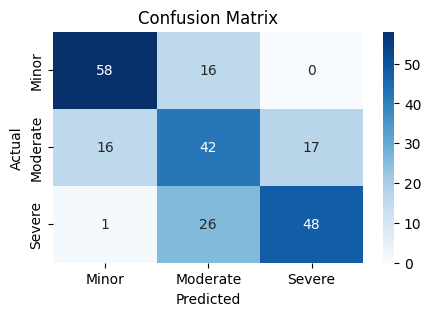

Test loss: 1.1350
Test accuracy: 65.62
Train loss: 0.3266
Train accuracy: 87.41
Recall: 0.66
Precision: 0.67
F1-score: 0.66


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

# Define your data directories
train_dir = '/content/drive/MyDrive/datasets severe new/train'
val_dir = '/content/drive/MyDrive/datasets severe new/validation'
test_dir = '/content/drive/MyDrive/datasets severe new/test'

# Define image size and batch size
img_size = (224, 224)
batch_size = 16  # Increase batch size for faster convergence

# Create data generators with additional augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom range
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of VGG19
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduce dropout rate
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a smaller learning rate
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=60,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Minor', 'Moderate', 'Severe'], yticklabels=['Minor', 'Moderate', 'Severe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_damage_VGG19_updated.h5')
